# *필요 라이브러리

In [1]:
#필요 라이브러리, 패키지 불러오기
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

In [2]:
#python에서 이상한 문자 나올 때 warnings import 하여 방지하기
import warnings
warnings.filterwarnings('ignore')
#plot 환경설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
%matplotlib inline
#음수 표시
matplotlib.rc('axes', unicode_minus=False)

------

# 1. 재발여부 분류 모델링을 위한 전처리

EDA, 통계적 검정을 통해 유의하게 판단되는 변수와, 도메인 지식을 통해 유의미하게 생각되는 변수 선택  
* '재발여부', '환자통증정도', '통증기간(월)', '가족력', '성별', '연령대', '입원기간', '직업', '수술 받은 계절', 'BMI'

In [3]:
df_derive = pd.read_csv('processed_data.csv')
selected_columns = ['재발여부','환자통증정도', '통증기간(월)', '가족력', '성별', '연령대', '입원기간', '직업', '수술 받은 계절', 'BMI']
X = df_derive[selected_columns]
X.head(3)

,재발여부,환자통증정도,통증기간(월),가족력,성별,연령대,입원기간,직업,수술 받은 계절,BMI
0,0,7,0.2,0.0,0,30-40대,1,사무직,봄,24.772097
1,0,7,5.0,1.0,0,10-20대,1,군인,봄,23.661439
2,0,5,24.0,0.0,0,10-20대,1,Unknown,봄,21.705129


## 1.1 Onehot Encoding

In [4]:
# # 원-핫 인코더 인스턴스 생성 및 적용
# categorical_features = ['연령대', '직업', '수술 받은 계절']
# onehot_encoder = OneHotEncoder(sparse=False)
# X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_features]),
#                          columns=onehot_encoder.get_feature_names_out(categorical_features))

# # 원핫 인코더를 'onehot_encoder.pkl' 파일로 저장
# with open('onehot_encoder.pkl', 'wb') as file:
#     pickle.dump(onehot_encoder, file)

# print("원핫 인코더가 'onehot_encoder.pkl'로 성공적으로 저장되었습니다.")

In [5]:
# 저장된 인코더 객체를 파일에서 로드
categorical_features = ['연령대', '직업', '수술 받은 계절']

with open('onehot_encoder.pkl', 'rb') as file:
    onehot_encoder = pickle.load(file)

# 로드된 기존의 인코딩 적용
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_features]),
                         columns=onehot_encoder.get_feature_names_out(categorical_features))

# 인코딩된 데이터와 나머지 데이터 합치기
X = X.drop(columns=categorical_features)
X = pd.concat([X, X_encoded], axis=1)

## 1.2 Min-Max Scaler

In [6]:
# Min-Max 스케일러 인스턴스 생성 및 적용
scaler = MinMaxScaler()
numeric_features = ['가족력', '성별', '입원기간', '환자통증정도', '통증기간(월)', 'BMI']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [7]:
# 스케일링된 데이터 확인
df_derive_encoded = X
df_derive_encoded.head(3)

,재발여부,환자통증정도,통증기간(월),가족력,성별,입원기간,BMI,연령대_10-20대,연령대_30-40대,연령대_50-60대,...,직업_운수업,직업_의료직,직업_자영업,직업_주부,직업_특수전문직,직업_학생,수술 받은 계절_가을,수술 받은 계절_겨울,수술 받은 계절_봄,수술 받은 계절_여름
0,0,0.666667,0.000556,0.0,0.0,0.021739,0.305039,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0.666667,0.013889,1.0,0.0,0.021739,0.272123,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.444444,0.066667,0.0,0.0,0.021739,0.214144,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
df_derive_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   재발여부         1889 non-null   int64  
 1   환자통증정도       1889 non-null   float64
 2   통증기간(월)      1889 non-null   float64
 3   가족력          1889 non-null   float64
 4   성별           1889 non-null   float64
 5   입원기간         1889 non-null   float64
 6   BMI          1889 non-null   float64
 7   연령대_10-20대   1889 non-null   float64
 8   연령대_30-40대   1889 non-null   float64
 9   연령대_50-60대   1889 non-null   float64
 10  연령대_70대 이상   1889 non-null   float64
 11  직업_Unknown   1889 non-null   float64
 12  직업_건설업       1889 non-null   float64
 13  직업_공무원       1889 non-null   float64
 14  직업_교사        1889 non-null   float64
 15  직업_군인        1889 non-null   float64
 16  직업_노동직       1889 non-null   float64
 17  직업_농업        1889 non-null   float64
 18  직업_무직        1889 non-null   float64
 19  직업_사무직

In [9]:
df_derive_encoded.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
재발여부,1889.0,0.118052,0.322755,0.0,0.000000,0.000000,0.000000,1.0
환자통증정도,1889.0,0.654079,0.230623,0.0,0.666667,0.666667,0.777778,1.0
통증기간(월),1889.0,0.016306,0.047893,0.0,0.002778,0.005556,0.011111,1.0
가족력,1889.0,0.048703,0.215303,0.0,0.000000,0.000000,0.000000,1.0
성별,1889.0,0.383801,0.486439,0.0,0.000000,0.000000,1.000000,1.0
입원기간,1889.0,0.037206,0.044670,0.0,0.021739,0.021739,0.043478,1.0
BMI,1889.0,0.283309,0.083902,0.0,0.235695,0.287006,0.310846,1.0
연령대_10-20대,1889.0,0.190577,0.392860,0.0,0.000000,0.000000,0.000000,1.0
연령대_30-40대,1889.0,0.548438,0.497780,0.0,0.000000,1.000000,1.000000,1.0
연령대_50-60대,1889.0,0.222340,0.415928,0.0,0.000000,0.000000,0.000000,1.0


# 2. Over sampling

In [10]:
# 목표 변수와 특성 분리
X = df_derive_encoded.drop(columns=['재발여부'])
y = df_derive_encoded['재발여부']

In [11]:
# RandomOverSampler를 사용하여 오버샘플링
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(X, y)

# 새로운 데이터프레임 생성
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['재발여부'])], axis=1)

In [12]:
# 데이터프레임 확인
print(df_resampled['재발여부'].value_counts())

재발여부
0    1666
1    1666
Name: count, dtype: int64


In [13]:
# 원래 데이터프레임에 오버샘플링된 데이터 추가
df_combined = pd.concat([df_derive_encoded, df_resampled], ignore_index=True)

# 데이터프레임 확인
print(df_combined['재발여부'].value_counts())

재발여부
0    3332
1    1889
Name: count, dtype: int64


# 3. Train, Test split

In [14]:
# '재발여부'를 타겟 변수로 설정하고 나머지를 피처로 설정
X = df_combined.drop(columns=['재발여부'])  # 피처
y = df_combined['재발여부']  # 타겟 변수

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)  # 테스트 세트는 전체 데이터의 20%로 설정
# 분할된 데이터 세트의 크기 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4176, 32)
X_test shape: (1045, 32)
y_train shape: (4176,)
y_test shape: (1045,)


# 4. Modeling

## 4.1 모델별 파라미터 설정

In [15]:
# 로지스틱 회귀 모델
log_reg = LogisticRegression(solver='liblinear', C=1.0)  # C 값 등 파라미터 조정 가능

# 결정 트리 모델
decision_tree = DecisionTreeClassifier(max_depth=4,
                                       min_samples_split=2)  # max_depth, min_samples_split 등 파라미터 조정 가능

# 랜덤 포레스트 모델
random_forest = RandomForestClassifier(n_estimators=100,
                                       max_depth=4,
                                       min_samples_split=2,
                                       random_state=42)  # n_estimators, max_depth 등 파라미터 조정 가능

# 서포트 벡터 머신 (SVM) 모델
svm = SVC(kernel='rbf',
          C=1.0,
          gamma='scale',
          random_state=42)  # kernel, C, gamma 등 파라미터 조정 가능

# Gradient Boosting Machine 모델
gbm = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 max_depth=4,
                                 random_state=42)  # n_estimators, learning_rate, max_depth 등 파라미터 조정 가능

# XGBoost 모델
xgboost_model = xgb.XGBClassifier(n_estimators=300,
                                  learning_rate=0.05,
                                  max_depth=4,
                                  use_label_encoder=False,
                                  eval_metric='logloss',
                                  random_state=42)  # n_estimators, learning_rate, max_depth 등 파라미터 조정 가능

# LightGBM 모델
lightgbm_model = lgb.LGBMClassifier(n_estimators=300,
                                    learning_rate=0.05,
                                    max_depth=4,
                                    random_state=42)  # n_estimators, learning_rate, max_depth 등 파라미터 조정 가능

# 다층 퍼셉트론 (MLP) 모델
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100),
                    activation='relu',
                    solver='adam',
                    max_iter=300, 
                    random_state=42)  # hidden_layer_sizes, activation, solver 등 파라미터 조정 가능

## 4.2 Accuracy, MSE 확인

In [16]:
# 모델 학습 및 평가를 위한 함수 정의
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)  # 테스트 세트에 대한 예측
    accuracy = accuracy_score(y_test, y_pred)  # 정확도 계산
    mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차 계산
    return accuracy, mse

# 각 모델을 학습시키고 테스트 세트로 평가
lr_acc, lr_mse = train_and_evaluate(log_reg, X_train, y_train, X_test, y_test)
dt_acc, dt_mse = train_and_evaluate(decision_tree, X_train, y_train, X_test, y_test)
rf_acc, rf_mse = train_and_evaluate(random_forest, X_train, y_train, X_test, y_test)
svm_acc, svm_mse = train_and_evaluate(svm, X_train, y_train, X_test, y_test)
gbm_acc, gbm_mse = train_and_evaluate(gbm, X_train, y_train, X_test, y_test)
xgb_acc, xgb_mse = train_and_evaluate(xgboost_model, X_train, y_train, X_test, y_test)
lgbm_acc, lgbm_mse = train_and_evaluate(lightgbm_model, X_train, y_train, X_test, y_test)
mlp_acc, mlp_mse = train_and_evaluate(mlp, X_train, y_train, X_test, y_test)

# 모델별 정확도 출력
print("Logistic Regression Accuracy:", lr_acc)
print("Logistic Regression MSE:", lr_mse)
print('*'*70)
print("Decision Tree Accuracy:", dt_acc)
print("Decision Tree MSE:", dt_mse)
print('*'*70)
print("Random Forest Accuracy:", rf_acc)
print("Random Forest MSE:", rf_mse)
print('*'*70)
print("SVM Accuracy:", svm_acc)
print("SVM MSE:", svm_mse)
print('*'*70)
print("GBM Accuracy:", gbm_acc)
print("GBM MSE:", gbm_mse)
print('*'*70)
print("XGBoost Accuracy:", xgb_acc)
print("XGBoost MSE:", xgb_mse)
print('*'*70)
print("LightGBM Accuracy:", lgbm_acc)
print("LightGBM MSE:", lgbm_mse)
print('*'*70)
print("MLP Accuracy:", mlp_acc)
print("MLP MSE:", mlp_mse)
print('*'*70)

Logistic Regression Accuracy: 0.6947368421052632
Logistic Regression MSE: 0.30526315789473685
**********************************************************************
Decision Tree Accuracy: 0.723444976076555
Decision Tree MSE: 0.276555023923445
**********************************************************************
Random Forest Accuracy: 0.692822966507177
Random Forest MSE: 0.307177033492823
**********************************************************************
SVM Accuracy: 0.737799043062201
SVM MSE: 0.26220095693779905
**********************************************************************
GBM Accuracy: 0.8679425837320575
GBM MSE: 0.1320574162679426
**********************************************************************
XGBoost Accuracy: 0.8258373205741627
XGBoost MSE: 0.17416267942583732
**********************************************************************
LightGBM Accuracy: 0.8421052631578947
LightGBM MSE: 0.15789473684210525
**********************************************************

## 4.3 Accuracy, Recall, Precision, F1-score

In [17]:
# 모델 평가를 위한 함수 정의
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)  # 테스트 세트에 대한 예측
    
    # 성능 평가 출력
    print(f"{model_name} Evaluation")
    print("-" * 60)
    
    # 정확도
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # 분류 보고서
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # 혼동 행렬
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n" + "-" * 60 + "\n")

# 모델 리스트
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "SVM": svm,
    "GBM": gbm,
    "XGBoost": xgboost_model,
    "LightGBM": lightgbm_model,
    "MLP": mlp
}

# 각 모델에 대해 평가 수행
for name, model in models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, name)

Logistic Regression Evaluation
------------------------------------------------------------
Accuracy: 0.6947368421052632

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.93      0.80       667
           1       0.70      0.28      0.39       378

    accuracy                           0.69      1045
   macro avg       0.70      0.60      0.60      1045
weighted avg       0.70      0.69      0.65      1045

Confusion Matrix:
 [[622  45]
 [274 104]]

------------------------------------------------------------

Decision Tree Evaluation
------------------------------------------------------------
Accuracy: 0.723444976076555

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81       667
           1       0.79      0.32      0.46       378

    accuracy                           0.72      1045
   macro avg       0.75      0.64      0.64      1045
weighted av

mse 확인 (0과 가까울 수록 성능이 좋은 모델)

## 4.3 오차행렬 시각화

Logistic Regression Confusion Matrix visualization
------------------------------------------------------------


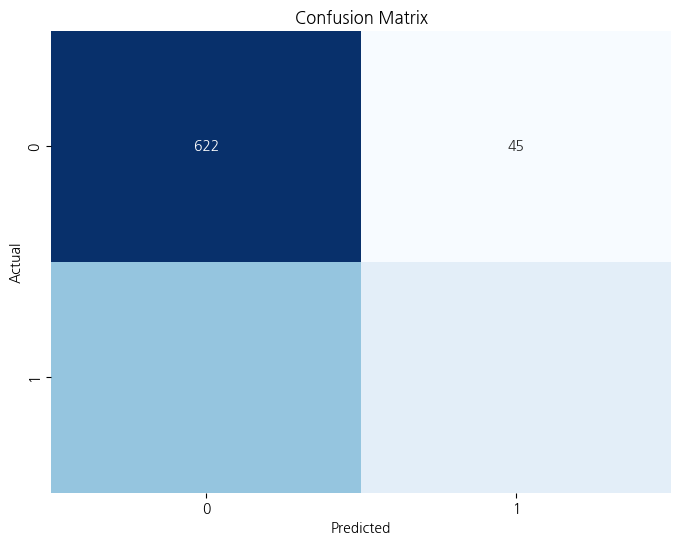


------------------------------------------------------------

Decision Tree Confusion Matrix visualization
------------------------------------------------------------


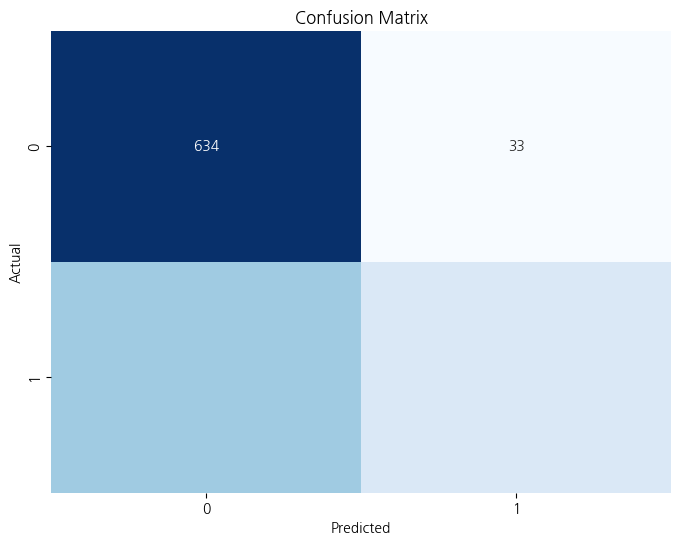


------------------------------------------------------------

Random Forest Confusion Matrix visualization
------------------------------------------------------------


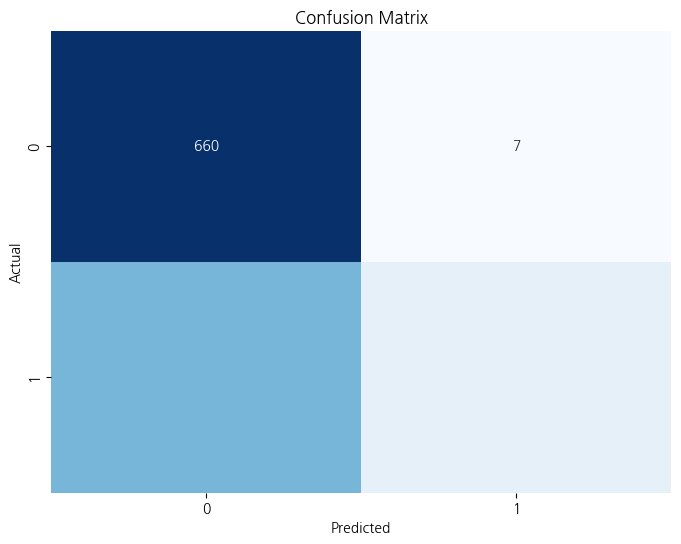


------------------------------------------------------------

SVM Confusion Matrix visualization
------------------------------------------------------------


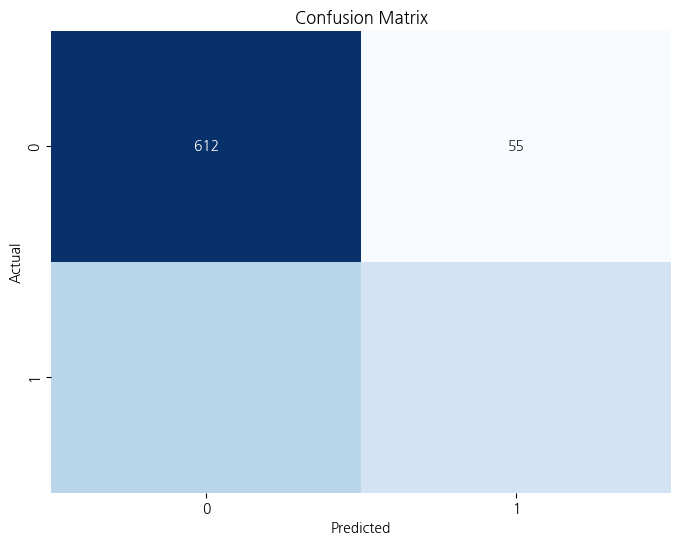


------------------------------------------------------------

GBM Confusion Matrix visualization
------------------------------------------------------------


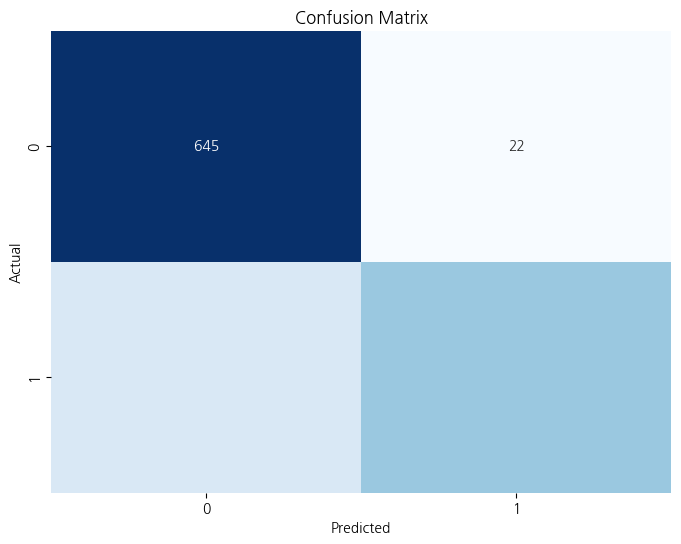


------------------------------------------------------------

XGBoost Confusion Matrix visualization
------------------------------------------------------------


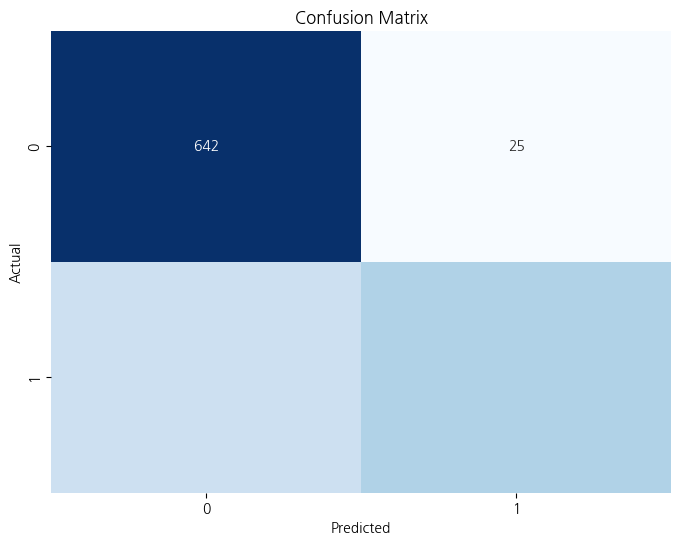


------------------------------------------------------------

LightGBM Confusion Matrix visualization
------------------------------------------------------------


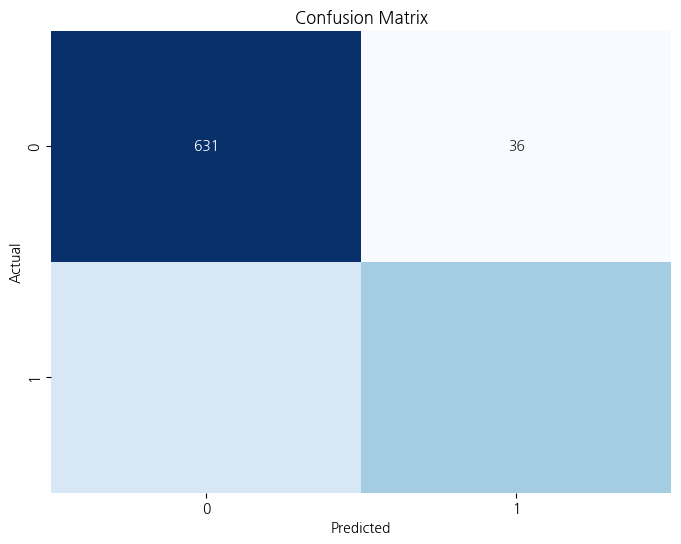


------------------------------------------------------------

MLP Confusion Matrix visualization
------------------------------------------------------------


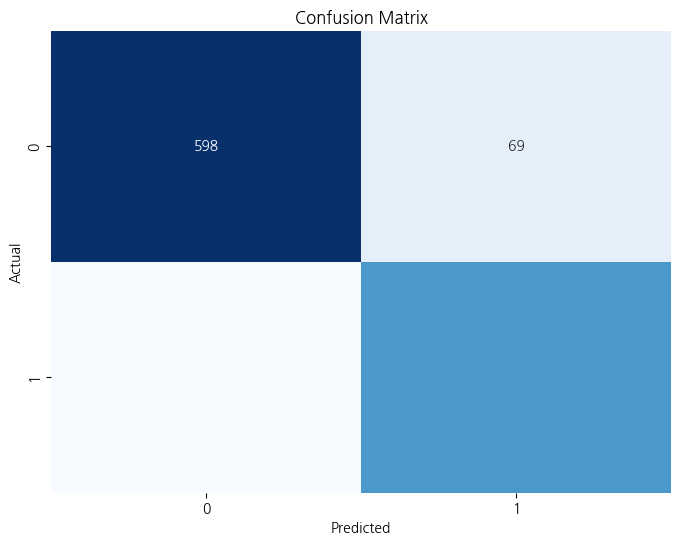


------------------------------------------------------------



In [18]:
# 모델 평가를 위한 함수 정의
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)  # 테스트 세트에 대한 예측
    
    # 성능 평가 출력
    print(f"{model_name} Confusion Matrix visualization")
    print("-" * 60)

    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    
    # 오차 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print("\n" + "-" * 60 + "\n")

# 각 모델에 대해 평가 수행
for name, model in models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, name)

---------------

### 모델로 저장

In [19]:
# import joblib
# model = mlp
# model.fit(X_train, y_train)

# joblib.dump(model, '0320mlp3.pkl')